# Imports

In [29]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Load and Inspect Data

In [3]:
iris = load_iris(as_frame=True)

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [4]:
X = iris.data
y = iris.target

In [5]:
X.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [6]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

# Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


Use stratification to ensure that the proportions of different classes in the target variable (y) are maintained in the training and testing sets.

In [8]:
y_train.value_counts(normalize=True)

target
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

In [9]:
y_test.value_counts(normalize=True) # The same proportions are maintained in the testing set

target
0    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64

# Preprocessing

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training 

In [11]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

tree = DecisionTreeClassifier(random_state=42) # Decision tree doesn't require scaling.
tree.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

# Evaluate on Training Set

In [12]:
y_train_pred_log_reg = log_reg.predict(X_train_scaled)

y_train_pred_tree = tree.predict(X_train)

y_train_pred_knn = knn.predict(X_train_scaled)

# Compute accuracy for each model
y_train_acc_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
y_train_acc_tree = accuracy_score(y_train, y_train_pred_tree)
y_train_acc_knn = accuracy_score(y_train, y_train_pred_knn)

# Store results in a small dictionary/table for comparison
results_train = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors'],
    'Accuracy': [y_train_acc_log_reg, y_train_acc_tree, y_train_acc_knn]
}

results_train

{'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors'],
 'Accuracy': [0.9583333333333334, 1.0, 0.975]}

# Evaluate on Testing Set

In [13]:
y_test_pred_log_reg = log_reg.predict(X_test_scaled)

y_test_pred_tree = tree.predict(X_test)

y_test_pred_knn = knn.predict(X_test_scaled)

# Compute accuracy for each model
y_test_acc_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
y_test_acc_tree = accuracy_score(y_test, y_test_pred_tree)
y_test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

# Store results in a small dictionary/table for comparison
results_test = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors'],
    'Accuracy': [y_test_acc_log_reg, y_test_acc_tree, y_test_acc_knn]
}

results_test

{'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors'],
 'Accuracy': [0.9333333333333333, 0.9333333333333333, 0.9333333333333333]}

# Confusion Matrix

### Logistic Regression

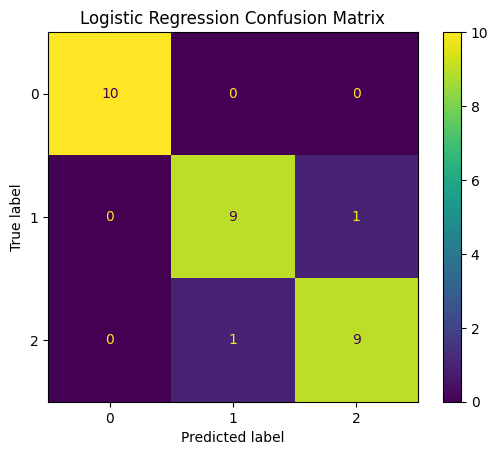

In [14]:
log_reg_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_log_reg)

plt.title("Logistic Regression Confusion Matrix")
plt.show()

### Decision Tree

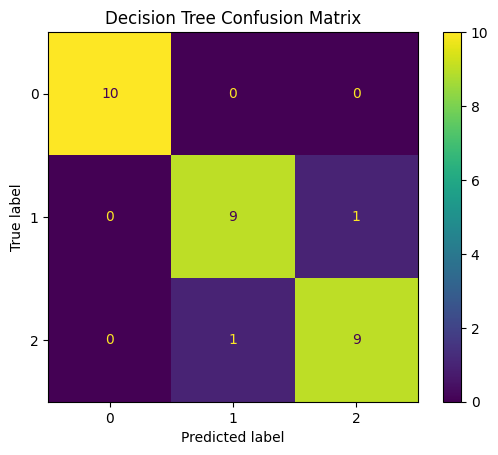

In [15]:
tree_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_tree)

plt.title("Decision Tree Confusion Matrix")
plt.show()

### KNN

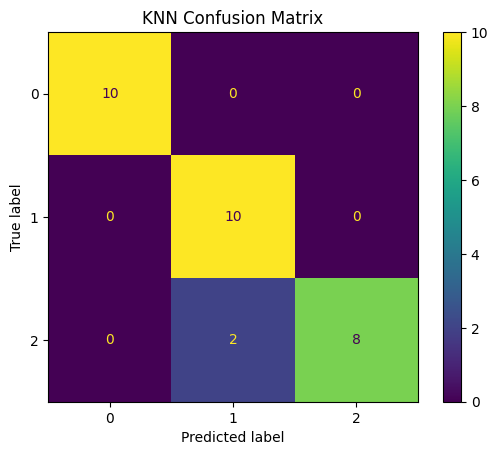

In [16]:
knn_cm = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_knn)

plt.title("KNN Confusion Matrix")
plt.show()

# Conclusion

**Highest Accuracy:** All three models achieved identical test accuracy of 93.3%, demonstrating that the iris dataset is relatively easy to classify with any reasonable algorithm.

**Misclassification Patterns:** Both Logistic Regression and Decision Tree made identical errors. KNN showed a different color pattern.

# Model Persistence

Use joblib to persist model.

Not:
- ONNX: My deployment / model serving will have access to Python, no need to use ONNX then.
- cloudpickle: Good for user-defined models... I am only using scikit-learn's built-in models.
- Pickle: Joblib is just more memory efficient.
- skops.io: No need for the security. I trust the model that I have built and scikit-learn.

In [ ]:
joblib.dump(log_reg, './log_reg.joblib')
joblib.dump(scaler, './scaler.joblib')

print("Model and Scaler saved in ./models/log_reg.joblib and ./models/scaler.joblib")

# Convert into ONNX format.
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', log_reg)
])

onx = convert_sklearn(pipeline, initial_types=[('input', FloatTensorType([None, 4]))])

# Save ONNX model
with open('./models/log_reg.onnx', 'wb') as f:
    f.write(onx.SerializeToString())